In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.sulfur.constant as const
from utils.CaImageCSV import CaImageCSV

In [2]:
def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

In [3]:
def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

In [4]:
def splitted_context_name(context_name, index):
    return '%s_%d' % (context_name, index)

def build_matrix_index(context_name, cells):
    index_df = pd.DataFrame(data=([context_name] * len(cells)))
    index_df.columns = ['context']
    cells = cells.reset_index(drop=True)
    index_df['cell_name'] = cells
    return pd.MultiIndex.from_frame(index_df, names=['context_name', 'cell_name'])

def split_matrix(matrix, context_name):
    matrix_1 = matrix.iloc[0:400, :]
    matrix_2 = matrix.iloc[900:1300, :]
    matrix_3 = matrix.iloc[1800:2200, :]
    
    matrix_1.rename(lambda x: splitted_context_name(x, 1), inplace=True)
    matrix_2.rename(lambda x: splitted_context_name(x, 2), inplace=True)
    matrix_3.rename(lambda x: splitted_context_name(x, 3), inplace=True)
    
    return matrix_1, matrix_2, matrix_3

In [35]:
a = np.arange(4).reshape(2,2)
b = np.arange(4, 8).reshape(2,2)
print(a)
print(b)
pairwise_distances(a, b)

[[0 1]
 [2 3]]
[[4 5]
 [6 7]]


array([[5.65685425, 8.48528137],
       [2.82842712, 5.65685425]])

In [5]:
index = const.ANIMAL_NAMES
column_df = pd.DataFrame()
column_df['cell type'] = ['engram', 'engram', 'engram', 'engram', 'engram', 'engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram']
print(column_df)
print(['A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1', 'A4postES_2', 'A4postES_3'] * 2)
column_df['context'] = ['A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1', 'A4postES_2', 'A4postES_3'] * 2
columns = pd.MultiIndex.from_frame(column_df)
df = pd.DataFrame(0.0, columns=columns, index=index)
for animal_name in const.ANIMAL_NAMES:
    file_path = './resources/%s_Longitudinal_Traces.csv' % animal_name
    csv = CaImageCSV(file_path)
    
    A1postES_data = csv.filtered_by_context('A1postES').astype(float).copy(deep=True)
    A1postES_data = csv.optimize_std(A1postES_data)
    A1postES_data.reset_index(level=1, drop=True, inplace=True)
    
    A1postES_engram = A1postES_data.loc[:, csv.engram_cells()]
    A1postES_non_engram = A1postES_data.loc[:, csv.non_engram_cells()]
    
    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    
    A4postES_data = csv.filtered_by_context('A4postES').astype(float).copy(deep=True)
    A4postES_data = csv.optimize_std(A4postES_data)
    A4postES_data.reset_index(level=1, drop=True, inplace=True)
    
    A4postES_engram = A4postES_data.loc[:, csv.engram_cells()]
    A4postES_non_engram = A4postES_data.loc[:, csv.non_engram_cells()]
    
    A4postES_nan_engram_cells = all_nan_cells(A4postES_engram)
    A4postES_nan_non_engram_cells = all_nan_cells(A4postES_non_engram)
    
    droped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, A4postES_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, A4postES_nan_non_engram_cells)
    
    A1postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    A4postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A4postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    engram_A1postES_1, engram_A1postES_2, engram_A1postES_3 = split_matrix(A1postES_engram, 'A1postES')
    engram_A4postES_1, engram_A4postES_2, engram_A4postES_3 = split_matrix(A4postES_engram, 'A4postES')
    
    non_engram_A1postES_1, non_engram_A1postES_2, non_engram_A1postES_3 = split_matrix(A1postES_non_engram, 'A1postES')
    non_engram_A4postES_1, non_engram_A4postES_2, non_engram_A4postES_3 = split_matrix(A4postES_non_engram, 'A4postES')
    
    df.loc[animal_name, ('engram', 'A1postES_1')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A1postES_1))
    df.loc[animal_name, ('engram', 'A1postES_2')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A1postES_2))
    df.loc[animal_name, ('engram', 'A1postES_3')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A1postES_3))
    df.loc[animal_name, ('engram', 'A4postES_1')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A4postES_1))
    df.loc[animal_name, ('engram', 'A4postES_2')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A4postES_2))
    df.loc[animal_name, ('engram', 'A4postES_3')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A4postES_3))
    
    df.loc[animal_name, ('non-engram', 'A1postES_1')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A1postES_1))
    df.loc[animal_name, ('non-engram', 'A1postES_2')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A1postES_2))
    df.loc[animal_name, ('non-engram', 'A1postES_3')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A1postES_3))
    df.loc[animal_name, ('non-engram', 'A4postES_1')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A4postES_1))
    df.loc[animal_name, ('non-engram', 'A4postES_2')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A4postES_2))
    df.loc[animal_name, ('non-engram', 'A4postES_3')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A4postES_3))
    
df

     cell type
0       engram
1       engram
2       engram
3       engram
4       engram
5       engram
6   non-engram
7   non-engram
8   non-engram
9   non-engram
10  non-engram
11  non-engram
['A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1', 'A4postES_2', 'A4postES_3', 'A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1', 'A4postES_2', 'A4postES_3']


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

cell type        engram                                              \
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2   
ID181106CreA   7.244848   7.284362   7.868483   8.442262   8.488234   
ID181106CreB   4.513434   4.528507   4.931593   5.429156   5.241358   
ID181106CreC   5.081714   5.629836   6.351111   8.023817   7.553569   
ID181106CreG   5.342127   6.360888   5.970941   7.585547   7.213434   
ID181106CreH   8.981726   7.927332   9.510930  10.750735  10.402838   
ID181106CreI   6.960119   9.097066   7.916514  10.795093   9.168371   
ID181106CreK   7.362404   7.608130   7.195432   7.774368   8.046985   
ID181106CreL   5.711946   5.729035   5.493843   6.980963   6.448790   
ID181106CreN   5.417414   5.601303   6.603029   7.762605   7.909104   
ID181106CreQ   5.743435   5.705794   5.378438   6.523025   7.364942   

cell type               non-engram                                   \
context      A4postES_3 A1postES_1 A1postES_2 A1postES_3 A4postES_1   
ID181106CreA   8.539134  26.981630  27.765946  26.720392  30.785717   
ID181106CreB   5.264964  17.965414  17.952879  17.092825  19.358826   
ID181106CreC   7.447053  18.120970  19.338848  20.099331  24.459712   
ID181106CreG   6.875269  24.824327  25.070929  25.971154  28.241208   
ID181106CreH  11.017735  21.685421  22.791997  23.271951  26.356497   
ID181106CreI   9.906990  17.236307  21.538695  19.071629  22.410600   
ID181106CreK   7.350600  27.058040  27.092816  25.571985  29.100890   
ID181106CreL   6.677607  24.526263  25.863392  25.641962  30.452088   
ID181106CreN   7.577168  22.320191  25.717867  25.309299  32.078219   
ID181106CreQ   6.680253  24.585018  25.920498  25.888579  29.856058   

cell type                           
context      A4postES_2 A4postES_3  
ID181106CreA  30.988091  29.882736  
ID181106CreB  20.847516  19.460415  
ID181106CreC  23.785644  23.370279  
ID181106CreG  29.427996  27.135498  
ID181106CreH  24.817590  26.671955  
ID181106CreI  21.344604  21.273591  
ID181106CreK  29.060666  28.328683  
ID181106CreL  28.924545  27.847153  
ID181106CreN  30.508190  30.735435  
ID181106CreQ  29.341821  29.328155

In [6]:
df.mean()

cell type   context   
engram      A1postES_1     6.235917
            A1postES_2     6.547225
            A1postES_3     6.722031
            A4postES_1     8.006757
            A4postES_2     7.783762
            A4postES_3     7.733677
non-engram  A1postES_1    22.530358
            A1postES_2    23.905387
            A1postES_3    23.463911
            A4postES_1    27.309982
            A4postES_2    26.904666
            A4postES_3    26.403390
dtype: float64

In [7]:
engram_distances = df.iloc[:, 0:6]
non_engram_distances = df.iloc[:, 6:]
print(engram_distances)
print(non_engram_distances)

cell type        engram                                                       
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2 A4postES_3
ID181106CreA   7.244848   7.284362   7.868483   8.442262   8.488234   8.539134
ID181106CreB   4.513434   4.528507   4.931593   5.429156   5.241358   5.264964
ID181106CreC   5.081714   5.629836   6.351111   8.023817   7.553569   7.447053
ID181106CreG   5.342127   6.360888   5.970941   7.585547   7.213434   6.875269
ID181106CreH   8.981726   7.927332   9.510930  10.750735  10.402838  11.017735
ID181106CreI   6.960119   9.097066   7.916514  10.795093   9.168371   9.906990
ID181106CreK   7.362404   7.608130   7.195432   7.774368   8.046985   7.350600
ID181106CreL   5.711946   5.729035   5.493843   6.980963   6.448790   6.677607
ID181106CreN   5.417414   5.601303   6.603029   7.762605   7.909104   7.577168
ID181106CreQ   5.743435   5.705794   5.378438   6.523025   7.364942   6.680253
cell type    non-engram                             

In [8]:
eng_mean = engram_distances.mean()
eng_mean -= eng_mean[0]
eng_mean

cell type  context   
engram     A1postES_1    0.000000
           A1postES_2    0.311309
           A1postES_3    0.486115
           A4postES_1    1.770840
           A4postES_2    1.547846
           A4postES_3    1.497760
dtype: float64

In [9]:
non_eng_mean = non_engram_distances.mean()
non_eng_mean -= non_eng_mean[0]
non_eng_mean

cell type   context   
non-engram  A1postES_1    0.000000
            A1postES_2    1.375029
            A1postES_3    0.933553
            A4postES_1    4.779624
            A4postES_2    4.374308
            A4postES_3    3.873032
dtype: float64

In [10]:
eng_mean.index.get_level_values('context').to_numpy()

array(['A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1',
       'A4postES_2', 'A4postES_3'], dtype=object)

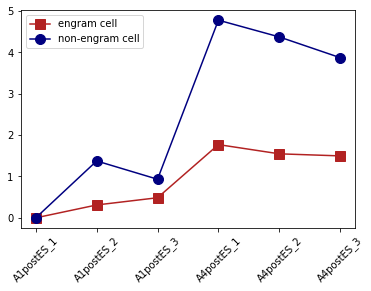

In [11]:
x = eng_mean.index.get_level_values('context').to_numpy()
plt.plot(x, eng_mean, marker='s', markersize=10, label='engram cell', c='firebrick')
plt.plot(x, non_eng_mean, marker='o', markersize=10, label='non-engram cell', c='navy')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [12]:
df.to_csv('./resources/pairwise_distance_for_A1postES_origin.csv')

In [13]:
df

cell type        engram                                              \
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2   
ID181106CreA   7.244848   7.284362   7.868483   8.442262   8.488234   
ID181106CreB   4.513434   4.528507   4.931593   5.429156   5.241358   
ID181106CreC   5.081714   5.629836   6.351111   8.023817   7.553569   
ID181106CreG   5.342127   6.360888   5.970941   7.585547   7.213434   
ID181106CreH   8.981726   7.927332   9.510930  10.750735  10.402838   
ID181106CreI   6.960119   9.097066   7.916514  10.795093   9.168371   
ID181106CreK   7.362404   7.608130   7.195432   7.774368   8.046985   
ID181106CreL   5.711946   5.729035   5.493843   6.980963   6.448790   
ID181106CreN   5.417414   5.601303   6.603029   7.762605   7.909104   
ID181106CreQ   5.743435   5.705794   5.378438   6.523025   7.364942   

cell type               non-engram                                   \
context      A4postES_3 A1postES_1 A1postES_2 A1postES_3 A4postES_1   
ID181106CreA   8.539134  26.981630  27.765946  26.720392  30.785717   
ID181106CreB   5.264964  17.965414  17.952879  17.092825  19.358826   
ID181106CreC   7.447053  18.120970  19.338848  20.099331  24.459712   
ID181106CreG   6.875269  24.824327  25.070929  25.971154  28.241208   
ID181106CreH  11.017735  21.685421  22.791997  23.271951  26.356497   
ID181106CreI   9.906990  17.236307  21.538695  19.071629  22.410600   
ID181106CreK   7.350600  27.058040  27.092816  25.571985  29.100890   
ID181106CreL   6.677607  24.526263  25.863392  25.641962  30.452088   
ID181106CreN   7.577168  22.320191  25.717867  25.309299  32.078219   
ID181106CreQ   6.680253  24.585018  25.920498  25.888579  29.856058   

cell type                           
context      A4postES_2 A4postES_3  
ID181106CreA  30.988091  29.882736  
ID181106CreB  20.847516  19.460415  
ID181106CreC  23.785644  23.370279  
ID181106CreG  29.427996  27.135498  
ID181106CreH  24.817590  26.671955  
ID181106CreI  21.344604  21.273591  
ID181106CreK  29.060666  28.328683  
ID181106CreL  28.924545  27.847153  
ID181106CreN  30.508190  30.735435  
ID181106CreQ  29.341821  29.328155

In [14]:
A1_1 = df.loc[:, ('engram', 'A1postES_1')].to_numpy()
A1_1

array([7.24484823, 4.51343401, 5.08171391, 5.34212744, 8.98172589,
       6.96011934, 7.36240424, 5.71194558, 5.41741408, 5.74343507])

In [15]:
for index, rows in df.iloc[:, 0:6].iterrows():
    first_value = rows[0]
    rows -= first_value
for index, rows in df.iloc[:, 6:].iterrows():
    first_value = rows[0]
    rows -= first_value
df

cell type        engram                                              \
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2   
ID181106CreA        0.0   0.039514   0.623634   1.197413   1.243385   
ID181106CreB        0.0   0.015073   0.418159   0.915722   0.727924   
ID181106CreC        0.0   0.548122   1.269397   2.942103   2.471855   
ID181106CreG        0.0   1.018760   0.628814   2.243420   1.871307   
ID181106CreH        0.0  -1.054394   0.529204   1.769009   1.421112   
ID181106CreI        0.0   2.136947   0.956395   3.834974   2.208252   
ID181106CreK        0.0   0.245726  -0.166972   0.411964   0.684580   
ID181106CreL        0.0   0.017089  -0.218103   1.269017   0.736844   
ID181106CreN        0.0   0.183889   1.185615   2.345191   2.491690   
ID181106CreQ        0.0  -0.037641  -0.364997   0.779590   1.621507   

cell type               non-engram                                   \
context      A4postES_3 A1postES_1 A1postES_2 A1postES_3 A4postES_1   
ID181106CreA   1.294285        0.0   0.784316  -0.261238   3.804087   
ID181106CreB   0.751530        0.0  -0.012535  -0.872589   1.393412   
ID181106CreC   2.365339        0.0   1.217878   1.978361   6.338742   
ID181106CreG   1.533141        0.0   0.246602   1.146828   3.416881   
ID181106CreH   2.036009        0.0   1.106576   1.586529   4.671075   
ID181106CreI   2.946871        0.0   4.302388   1.835322   5.174294   
ID181106CreK  -0.011804        0.0   0.034775  -1.486056   2.042850   
ID181106CreL   0.965662        0.0   1.337129   1.115699   5.925825   
ID181106CreN   2.159754        0.0   3.397676   2.989108   9.758028   
ID181106CreQ   0.936818        0.0   1.335480   1.303561   5.271039   

cell type                           
context      A4postES_2 A4postES_3  
ID181106CreA   4.006462   2.901106  
ID181106CreB   2.882102   1.495001  
ID181106CreC   5.664675   5.249309  
ID181106CreG   4.603669   2.311171  
ID181106CreH   3.132169   4.986533  
ID181106CreI   4.108298   4.037285  
ID181106CreK   2.002626   1.270643  
ID181106CreL   4.398281   3.320889  
ID181106CreN   8.187999   8.415244  
ID181106CreQ   4.756803   4.743137

In [16]:
df.to_csv('./resources/pairwise_distance_for_A1postES_after.csv')

In [17]:
df.mean()

cell type   context   
engram      A1postES_1    0.000000
            A1postES_2    0.311309
            A1postES_3    0.486115
            A4postES_1    1.770840
            A4postES_2    1.547846
            A4postES_3    1.497760
non-engram  A1postES_1    0.000000
            A1postES_2    1.375029
            A1postES_3    0.933553
            A4postES_1    4.779624
            A4postES_2    4.374308
            A4postES_3    3.873032
dtype: float64

In [18]:
df.sem()

cell type   context   
engram      A1postES_1    0.000000
            A1postES_2    0.261304
            A1postES_3    0.183078
            A4postES_1    0.338735
            A4postES_2    0.222980
            A4postES_3    0.280013
non-engram  A1postES_1    0.000000
            A1postES_2    0.448506
            A1postES_3    0.438637
            A4postES_1    0.750580
            A4postES_2    0.537580
            A4postES_3    0.672195
dtype: float64

In [19]:
engram_distances = df.iloc[:, 0:6]
non_engram_distances = df.iloc[:, 6:]
print(engram_distances)
print(non_engram_distances)

cell type        engram                                                       
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2 A4postES_3
ID181106CreA        0.0   0.039514   0.623634   1.197413   1.243385   1.294285
ID181106CreB        0.0   0.015073   0.418159   0.915722   0.727924   0.751530
ID181106CreC        0.0   0.548122   1.269397   2.942103   2.471855   2.365339
ID181106CreG        0.0   1.018760   0.628814   2.243420   1.871307   1.533141
ID181106CreH        0.0  -1.054394   0.529204   1.769009   1.421112   2.036009
ID181106CreI        0.0   2.136947   0.956395   3.834974   2.208252   2.946871
ID181106CreK        0.0   0.245726  -0.166972   0.411964   0.684580  -0.011804
ID181106CreL        0.0   0.017089  -0.218103   1.269017   0.736844   0.965662
ID181106CreN        0.0   0.183889   1.185615   2.345191   2.491690   2.159754
ID181106CreQ        0.0  -0.037641  -0.364997   0.779590   1.621507   0.936818
cell type    non-engram                             

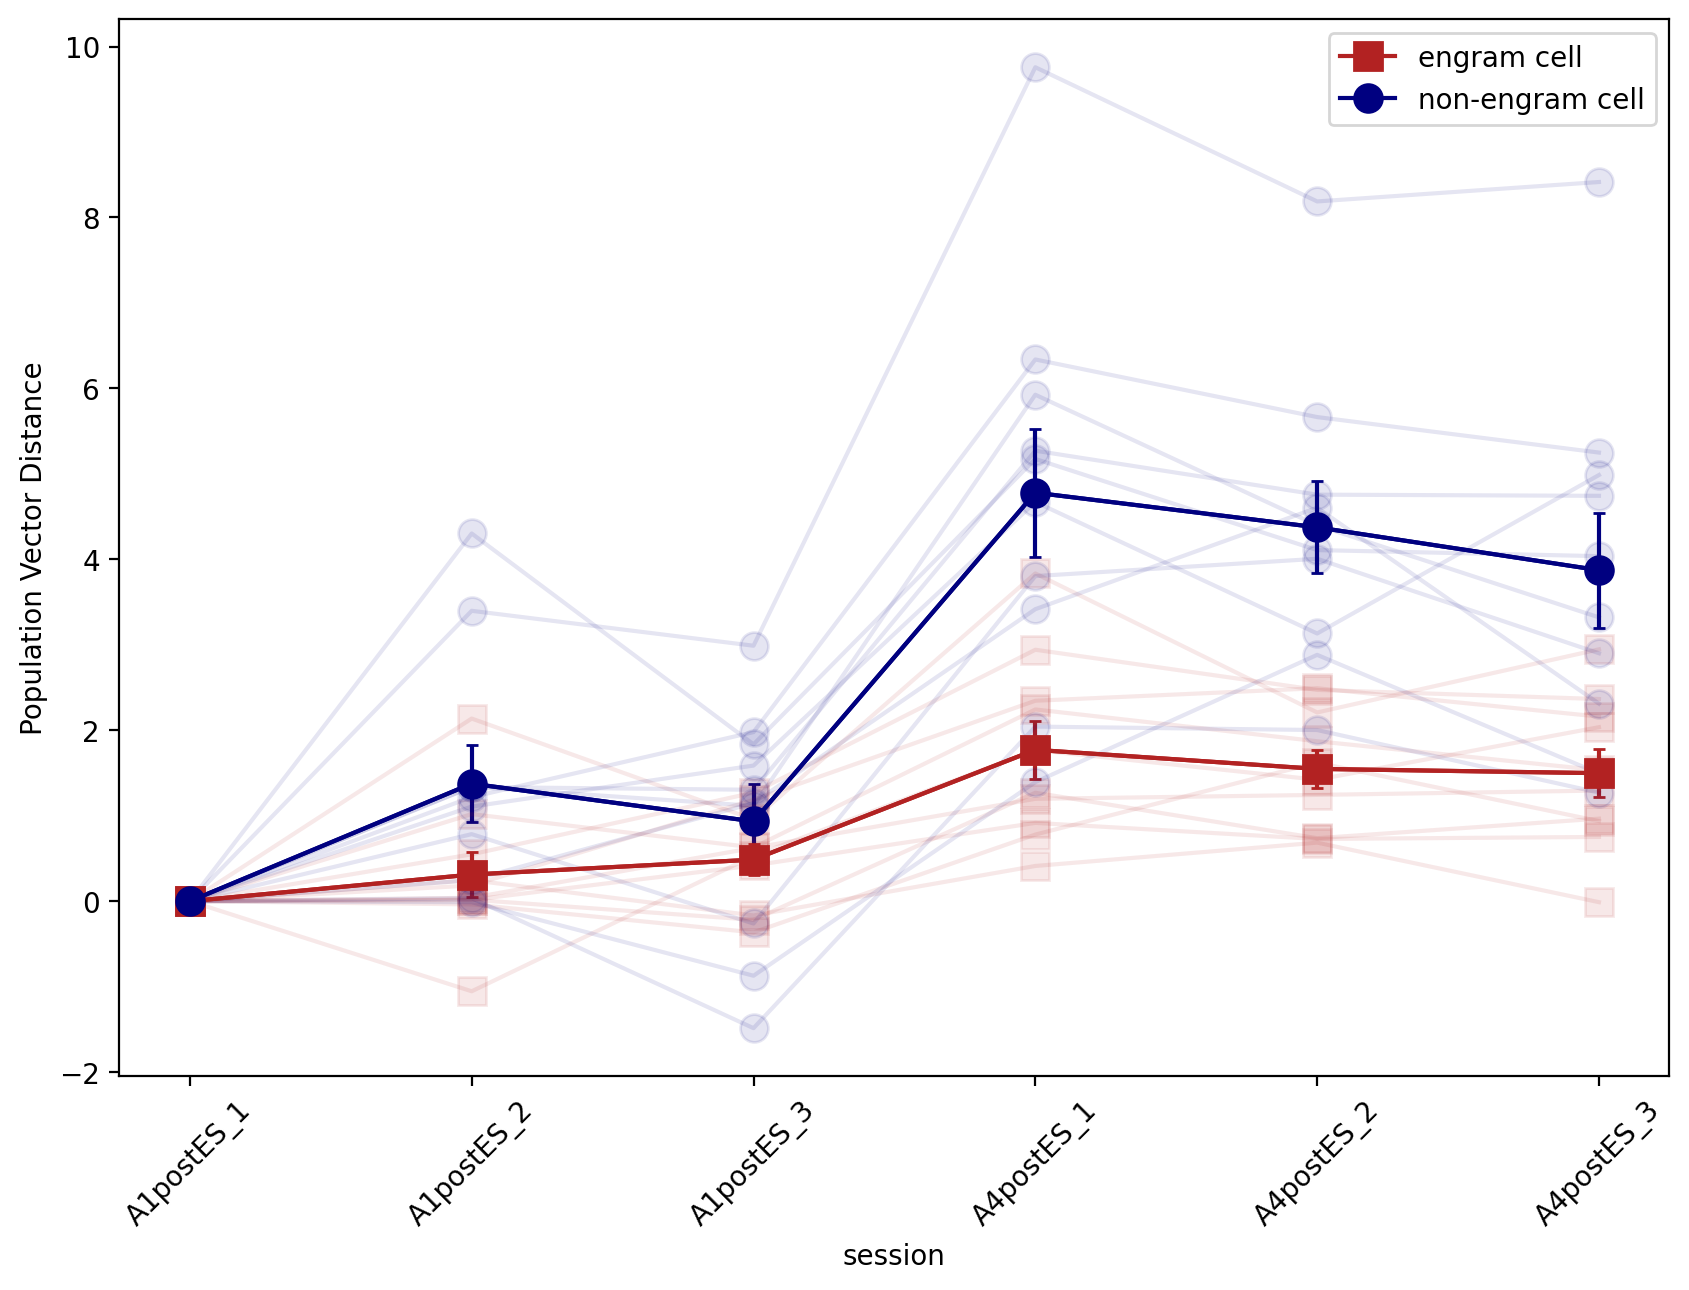

In [20]:
x = eng_mean.index.get_level_values('context').to_numpy()
engram_y, engram_err = engram_distances.mean(), engram_distances.sem()
non_engram_y, non_engram_err = non_engram_distances.mean(), non_engram_distances.sem()

plt.figure(figsize=(10, 7), dpi=200)
plt.errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
plt.plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
plt.errorbar(x, non_engram_y, yerr=non_engram_err, capsize=2, c='navy')
plt.plot(x, non_engram_y, marker='o', markersize=10, label='non-engram cell', c='navy', zorder=12)

for index, rows in engram_distances.iterrows():
    plt.plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in non_engram_distances.iterrows():
    plt.plot(x, rows, marker='o', markersize=10, c='navy', alpha=0.1)

plt.xticks(rotation=45)
plt.xlabel('session')
plt.ylabel('Population Vector Distance')
plt.legend()
plt.show()

In [21]:
index = const.ANIMAL_NAMES
column_df = pd.DataFrame()
column_df['cell type'] = ['engram', 'engram', 'engram', 'engram', 'engram', 'engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram', 'non-engram']
column_df['context'] = ['A1postES_1', 'A1postES_2', 'A1postES_3', 'A4postES_1', 'A4postES_2', 'A4postES_3'] * 2
columns = pd.MultiIndex.from_frame(column_df)
same_session_df = pd.DataFrame(0.0, columns=columns, index=index)
for animal_name in const.ANIMAL_NAMES:
    file_path = './resources/%s_Longitudinal_Traces.csv' % animal_name
    csv = CaImageCSV(file_path)
    
    A1postES_data = csv.filtered_by_context('A1postES').astype(float).copy(deep=True)
    A1postES_data = csv.optimize_std(A1postES_data)
    A1postES_data.reset_index(level=1, drop=True, inplace=True)
    
    A1postES_engram = A1postES_data.loc[:, csv.engram_cells()]
    A1postES_non_engram = A1postES_data.loc[:, csv.non_engram_cells()]
    
    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    
    A4postES_data = csv.filtered_by_context('A4postES').astype(float).copy(deep=True)
    A4postES_data = csv.optimize_std(A4postES_data)
    A4postES_data.reset_index(level=1, drop=True, inplace=True)
    
    A4postES_engram = A4postES_data.loc[:, csv.engram_cells()]
    A4postES_non_engram = A4postES_data.loc[:, csv.non_engram_cells()]
    
    A4postES_nan_engram_cells = all_nan_cells(A4postES_engram)
    A4postES_nan_non_engram_cells = all_nan_cells(A4postES_non_engram)
    
    droped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, A4postES_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, A4postES_nan_non_engram_cells)
    
    A1postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    A4postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A4postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    engram_A1postES_1, engram_A1postES_2, engram_A1postES_3 = split_matrix(A1postES_engram, 'A1postES')
    engram_A4postES_1, engram_A4postES_2, engram_A4postES_3 = split_matrix(A4postES_engram, 'A4postES')
    
    non_engram_A1postES_1, non_engram_A1postES_2, non_engram_A1postES_3 = split_matrix(A1postES_non_engram, 'A1postES')
    non_engram_A4postES_1, non_engram_A4postES_2, non_engram_A4postES_3 = split_matrix(A4postES_non_engram, 'A4postES')
    
    same_session_df.loc[animal_name, ('engram', 'A1postES_1')] = np.mean(pairwise_distances(engram_A1postES_1, engram_A1postES_1))
    same_session_df.loc[animal_name, ('engram', 'A1postES_2')] = np.mean(pairwise_distances(engram_A1postES_2, engram_A1postES_2))
    same_session_df.loc[animal_name, ('engram', 'A1postES_3')] = np.mean(pairwise_distances(engram_A1postES_3, engram_A1postES_3))
    same_session_df.loc[animal_name, ('engram', 'A4postES_1')] = np.mean(pairwise_distances(engram_A4postES_1, engram_A4postES_1))
    same_session_df.loc[animal_name, ('engram', 'A4postES_2')] = np.mean(pairwise_distances(engram_A4postES_2, engram_A4postES_2))
    same_session_df.loc[animal_name, ('engram', 'A4postES_3')] = np.mean(pairwise_distances(engram_A4postES_3, engram_A4postES_3))
    
    same_session_df.loc[animal_name, ('non-engram', 'A1postES_1')] = np.mean(pairwise_distances(non_engram_A1postES_1, non_engram_A1postES_1))
    same_session_df.loc[animal_name, ('non-engram', 'A1postES_2')] = np.mean(pairwise_distances(non_engram_A1postES_2, non_engram_A1postES_2))
    same_session_df.loc[animal_name, ('non-engram', 'A1postES_3')] = np.mean(pairwise_distances(non_engram_A1postES_3, non_engram_A1postES_3))
    same_session_df.loc[animal_name, ('non-engram', 'A4postES_1')] = np.mean(pairwise_distances(non_engram_A4postES_1, non_engram_A4postES_1))
    same_session_df.loc[animal_name, ('non-engram', 'A4postES_2')] = np.mean(pairwise_distances(non_engram_A4postES_2, non_engram_A4postES_2))
    same_session_df.loc[animal_name, ('non-engram', 'A4postES_3')] = np.mean(pairwise_distances(non_engram_A4postES_3, non_engram_A4postES_3))
    
same_session_df

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

cell type        engram                                              \
context      A1postES_1 A1postES_2 A1postES_3 A4postES_1 A4postES_2   
ID181106CreA   7.244848   6.162907   7.295988   7.098678   7.079015   
ID181106CreB   4.513434   4.254065   4.876286   4.870677   4.137400   
ID181106CreC   5.081714   5.312928   5.923419   7.491460   5.171325   
ID181106CreG   5.342127   6.164952   5.713318   7.178351   6.314918   
ID181106CreH   8.981726   6.050673   8.478491   9.567427   6.371290   
ID181106CreI   6.960119   8.596911   4.914205   9.118551   5.389738   
ID181106CreK   7.362404   6.468801   5.119668   6.855524   6.999667   
ID181106CreL   5.711946   4.758840   3.790209   5.321207   5.135278   
ID181106CreN   5.417414   3.900770   6.022880   5.967402   4.877403   
ID181106CreQ   5.743435   5.078475   3.998594   5.086949   6.893336   

cell type               non-engram                                   \
context      A4postES_3 A1postES_1 A1postES_2 A1postES_3 A4postES_1   
ID181106CreA   6.762195  26.981630  24.223955  22.274777  25.756718   
ID181106CreB   4.839419  17.965414  16.271793  14.012025  16.329184   
ID181106CreC   5.585960  18.120970  17.566631  18.372416  21.897964   
ID181106CreG   5.205639  24.824327  19.559845  22.062230  22.577053   
ID181106CreH   8.742096  21.685421  21.337982  21.933603  24.322533   
ID181106CreI   7.115166  17.236307  19.089330   9.791269  18.223797   
ID181106CreK   5.693317  27.058040  21.794369  17.604667  24.175759   
ID181106CreL   4.719465  24.526263  22.814060  21.809221  28.230595   
ID181106CreN   4.990981  22.320191  24.393218  22.677045  27.845273   
ID181106CreQ   4.920131  24.585018  23.321821  22.448088  26.906476   

cell type                           
context      A4postES_2 A4postES_3  
ID181106CreA  25.935045  24.050025  
ID181106CreB  18.334747  15.684585  
ID181106CreC  18.296575  19.107836  
ID181106CreG  26.947944  20.497080  
ID181106CreH  19.423837  22.952268  
ID181106CreI  14.706293  14.712352  
ID181106CreK  24.015660  21.144707  
ID181106CreL  23.845920  22.305327  
ID181106CreN  23.346264  23.831432  
ID181106CreQ  25.730271  24.188615

In [30]:
same_session_df.shape

(10, 12)

In [22]:
same_session_df.to_csv('./resources/pairwise_distance_for_same_session.csv')

In [23]:
engram_inner_session = same_session_df.iloc[:, 0:6]
engram_across_session = df.iloc[:, 0:6]

non_engram_inner_session = same_session_df.iloc[:, 6:]
non_engram_across_session = df.iloc[:, 6:]

In [28]:
def view_inner_across_figure(ax, inner_session_df, across_session_df, compared_session_name, color='', max_ylim=10, engram=True):
    base_session = inner_session_df.iloc[:, 0]
    compared_session = inner_session_df.loc[:, ('engram' if engram else 'non-engram', compared_session_name)]
    versus_session = across_session_df.loc[:, ('engram' if engram else 'non-engram', compared_session_name)]
    versus_session = versus_session + base_session
    
    base_session_color = 'lightsteelblue'
    ax.bar(x=0, height=base_session.mean(), yerr=base_session.sem(), capsize=8, align='center',color=base_session_color)
    ax.bar(x=1, height=compared_session.mean(), yerr=compared_session.sem(), capsize=8, align='center',color=color)
    ax.bar(x=2, height=versus_session.mean(), yerr=versus_session.sem(), capsize=8, align='center', linewidth=10, edgecolor=color, color=base_session_color)
    ax.tick_params(labelsize=20)
    ax.set_xticks(list(range(0, 3)))
    ax.set_ylim(0, max_ylim)
    compared_session_label = compared_session_name.replace('postES', '')
    ax.set_xticklabels(labels=['A1_1', compared_session_label, ('A1_1 v.s %s' % compared_session_label)], rotation=45)

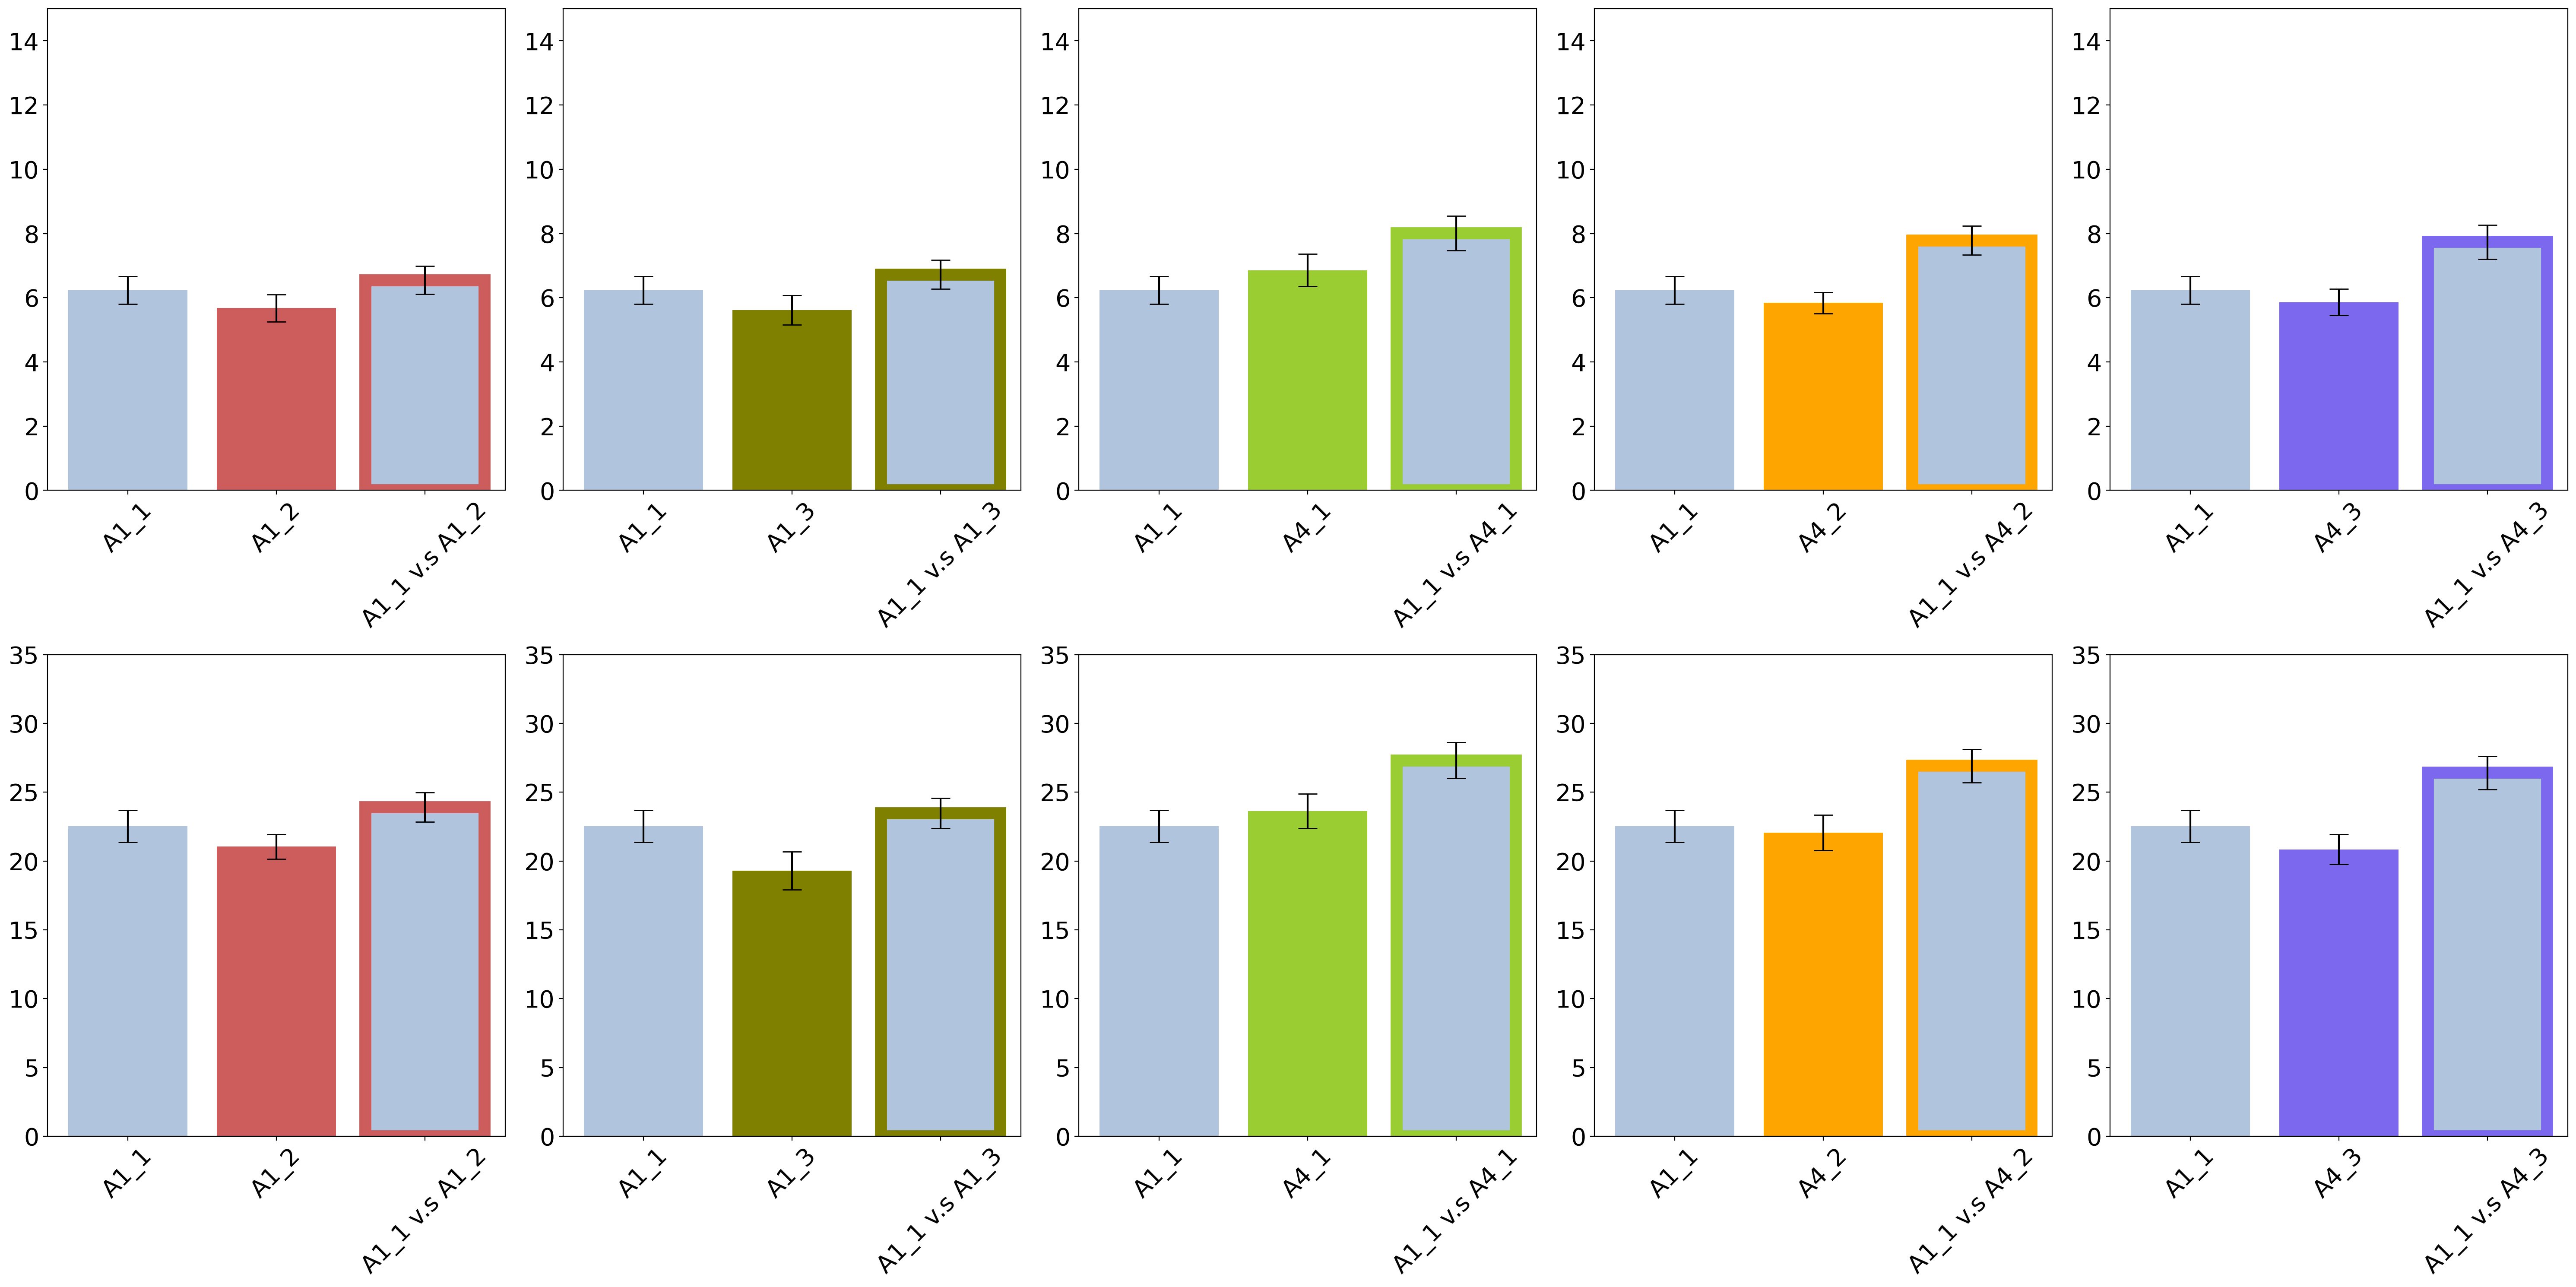

In [29]:
labels = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3', 'A1_1 v.s A1_2', 'A1_1 v.s A1_3', 'A1_1 v.s A4_1', 'A1_1 v.s A4_2', 'A1_1 v.s A4_3']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15), dpi=200)
view_inner_across_figure(axes[0][0], engram_inner_session, engram_across_session, 'A1postES_2', max_ylim=15, color='indianred')
view_inner_across_figure(axes[0][1], engram_inner_session, engram_across_session, 'A1postES_3', max_ylim=15, color='olive')
view_inner_across_figure(axes[0][2], engram_inner_session, engram_across_session, 'A4postES_1', max_ylim=15, color='yellowgreen')
view_inner_across_figure(axes[0][3], engram_inner_session, engram_across_session, 'A4postES_2', max_ylim=15, color='orange')
view_inner_across_figure(axes[0][4], engram_inner_session, engram_across_session, 'A4postES_3', max_ylim=15, color='mediumslateblue')

view_inner_across_figure(axes[1][0], non_engram_inner_session, non_engram_across_session, 'A1postES_2', color='indianred', max_ylim=35, engram=False)
view_inner_across_figure(axes[1][1], non_engram_inner_session, non_engram_across_session, 'A1postES_3', color='olive', max_ylim=35, engram=False)
view_inner_across_figure(axes[1][2], non_engram_inner_session, non_engram_across_session, 'A4postES_1', color='yellowgreen', max_ylim=35, engram=False)
view_inner_across_figure(axes[1][3], non_engram_inner_session, non_engram_across_session, 'A4postES_2', color='orange', max_ylim=35, engram=False)
view_inner_across_figure(axes[1][4], non_engram_inner_session, non_engram_across_session, 'A4postES_3', color='mediumslateblue', max_ylim=35, engram=False)

fig.tight_layout()
plt.show()